# Store extra information in the samping chains

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 140
mpl.rcParams['figure.dpi'] = 140
import numpy as np
from chainconsumer import ChainConsumer
# our own modules
from lace_manager.data import data_MPGADGET
from lace.emulator import gp_emulator
from lace.emulator import p1d_archive
from lace_manager.likelihood import likelihood
from lace_manager.likelihood import full_theory
from lace_manager.likelihood import lya_theory
from lace_manager.sampler import emcee_sampler
import time

### Set up mock data

Begin by picking a simulation to use as mock data, and creating a corresponding data object

In [2]:
# specify simulation to use to generate synthetic data
test_sim_label="h"
if type(test_sim_label)==int:
    drop_sim_number=test_sim_label
    print('will drop sim number {} from emulator'.format(drop_sim_number))
else:
    drop_sim_number=None

In [3]:
# specify simulation suite and P1D mesurements
basedir="/lace/emulator/sim_suites/Australia20/"
skewers_label='Ns500_wM0.05'
p1d_label=None
z_max=4.5
data=data_MPGADGET.P1D_MPGADGET(basedir=basedir,
                                skewers_label=skewers_label,
                                sim_label=test_sim_label,
                                zmax=z_max,pivot_scalar=0.05)

H0 = 7.4000E+01, Omega_b h^2 = 2.2000E-02, Omega_c h^2 = 1.2000E-01, Omega_k = 0.0000E+00, Omega_nu h^2 = 0.0000E+00, A_s = 2.0138E-09, n_s = 9.6756E-01, alpha_s = 0.0000E+00


### Emulator and training set

Create a set of training data to train an emulator

In [4]:
# Set up emulator training set
z_max=4
archive=p1d_archive.archiveP1D(basedir=basedir,drop_sim_number=drop_sim_number,
                            drop_tau_rescalings=True,z_max=z_max,
                            drop_temp_rescalings=True,skewers_label=skewers_label)

In [5]:
## Build emulator
paramList=['mF', 'sigT_Mpc', 'gamma', 'kF_Mpc', 'Delta2_p', 'n_p']
# specify k range
kmax_Mpc=8
emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,z_max=z_max,
                                verbose=False,paramList=paramList,train=True,
                                asymmetric_kernel=True,rbf_only=True,
                                emu_type="k_bin",passarchive=archive,
                                kmax_Mpc=kmax_Mpc)

 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/paramz/parameterized.py:61: RuntimeWarning:Don't forget to initialize by self.initialize_parameter()!


Training GP on 270 points
Optimised


### Set up a likelihood

Here we chose which parameters we want to sample, over which range and chose a prior. We pass the data and emulator objects to the likelihood.

In [6]:
# full theory (no compression)
theory_f=full_theory.FullTheory(zs=data.z,emulator=emu,theta_MC=True,
                                           use_compression=False,use_camb_fz=True)

In [7]:
# Set up likelihood object
free_param_limits_f=[[0.0099,0.0109],[1.1e-09, 3.19e-09], [0.89, 1.05],[-0.2, 0.2]]
free_param_names_f=["cosmomc_theta","As","ns","ln_tau_0"]
prior=None ## None for uniform prior, otherwise this value sets the width of the Gaussian within the unit prior volume

# Create a likelihood object using CMB parameters and including the CMB likelihood
like_f=likelihood.Likelihood(data=data,theory=theory_f,
                            free_param_names=free_param_names_f,
                            free_param_limits=free_param_limits_f,
                            prior_Gauss_rms=prior,pivot_scalar=0.05,
                            include_CMB=True)

### Sampler object

Here we configure our sampler, set the number of walkers, and decide whether or not we want to save the chain to be resumed or plot later on.

In [8]:
## Set up sampler
sampler_f = emcee_sampler.EmceeSampler(like=like_f,
                        free_param_names=free_param_names_f,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [9]:
for p in sampler_f.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

cosmomc_theta 0.010392466823954094 0.0099 0.0109
As 2.1e-09 1.1e-09 3.19e-09
ns 0.965 0.89 1.05
ln_tau_0 0.0 -0.2 0.2


In [10]:
n_burn_in=10
n_steps=50 ## Max number of steps to run

start = time.time()
sampler_f.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 60/60 [05:01<00:00,  5.03s/it]

Sampling took 304.8 seconds


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/lace-1.0.1-py3.8.egg/lace/sampler/emcee_sampler.py:724: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


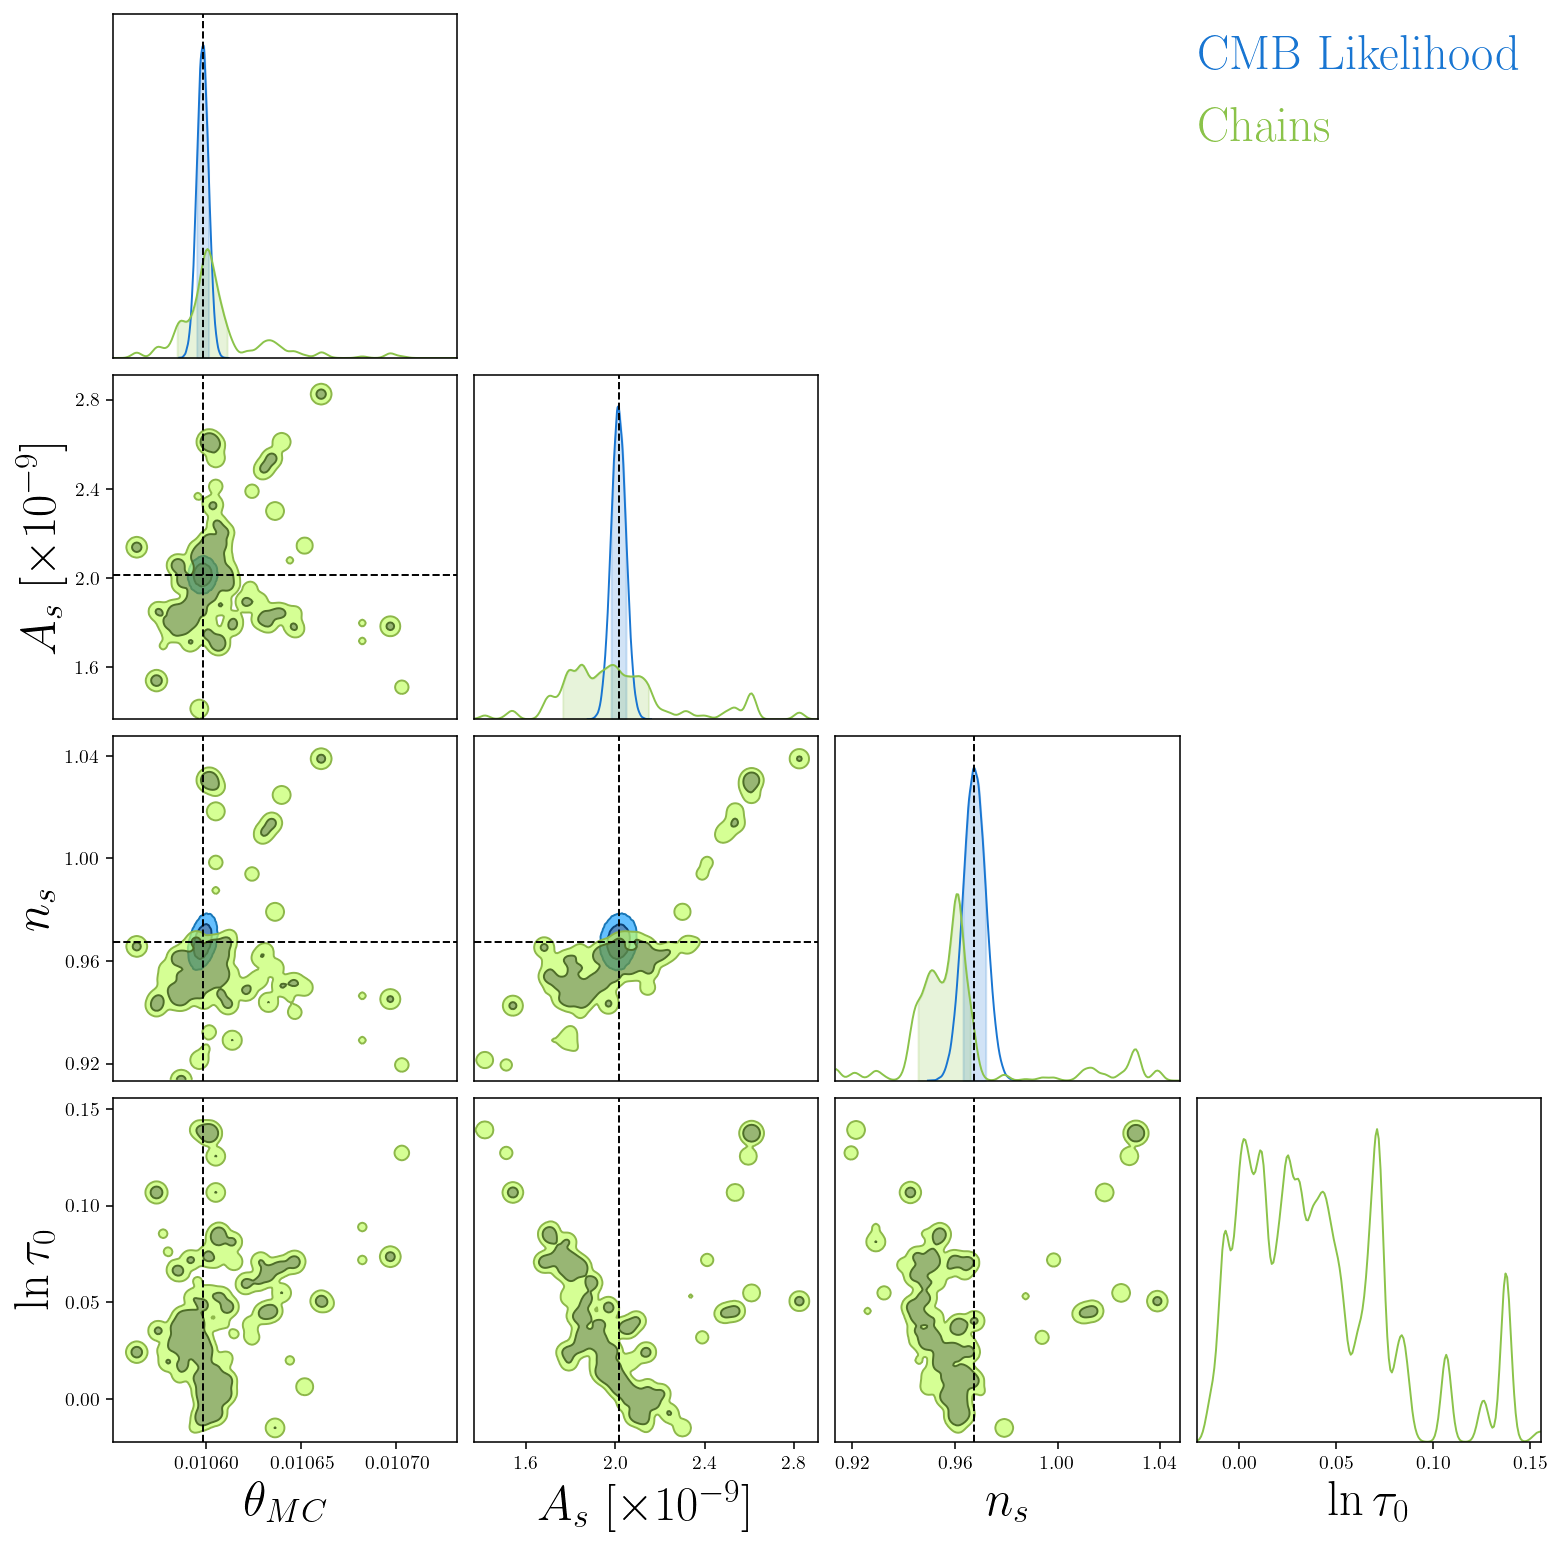

In [11]:
sampler_f.plot_corner(cmb_prior=True)

In [14]:
blobs_f=sampler_f.blobs
blobs_f['Delta2_star'][:5]

array([0.27890956, 0.53196611, 0.19748557, 0.36752981, 0.30927614])

### Redo for full_theory, but using compression to make calls

In [15]:
# full theory (including also compression)
theory_fc=full_theory.FullTheory(zs=data.z,emulator=emu,theta_MC=True,
                                           use_compression=True,use_camb_fz=True)

In [16]:
# Create a likelihood object using CMB parameters and including the CMB likelihood
like_fc=likelihood.Likelihood(data=data,theory=theory_fc,
                            free_param_names=free_param_names_f,
                            free_param_limits=free_param_limits_f,
                            prior_Gauss_rms=prior,pivot_scalar=0.05,
                            include_CMB=True)

In [24]:
# Set up sampler
sampler_fc=emcee_sampler.EmceeSampler(like=like_fc,
                        free_param_names=free_param_names_f,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [25]:
start = time.time()
sampler_fc.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 60/60 [05:23<00:00,  5.40s/it]

Sampling took 327.5 seconds


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/lace-1.0.1-py3.8.egg/lace/sampler/emcee_sampler.py:724: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


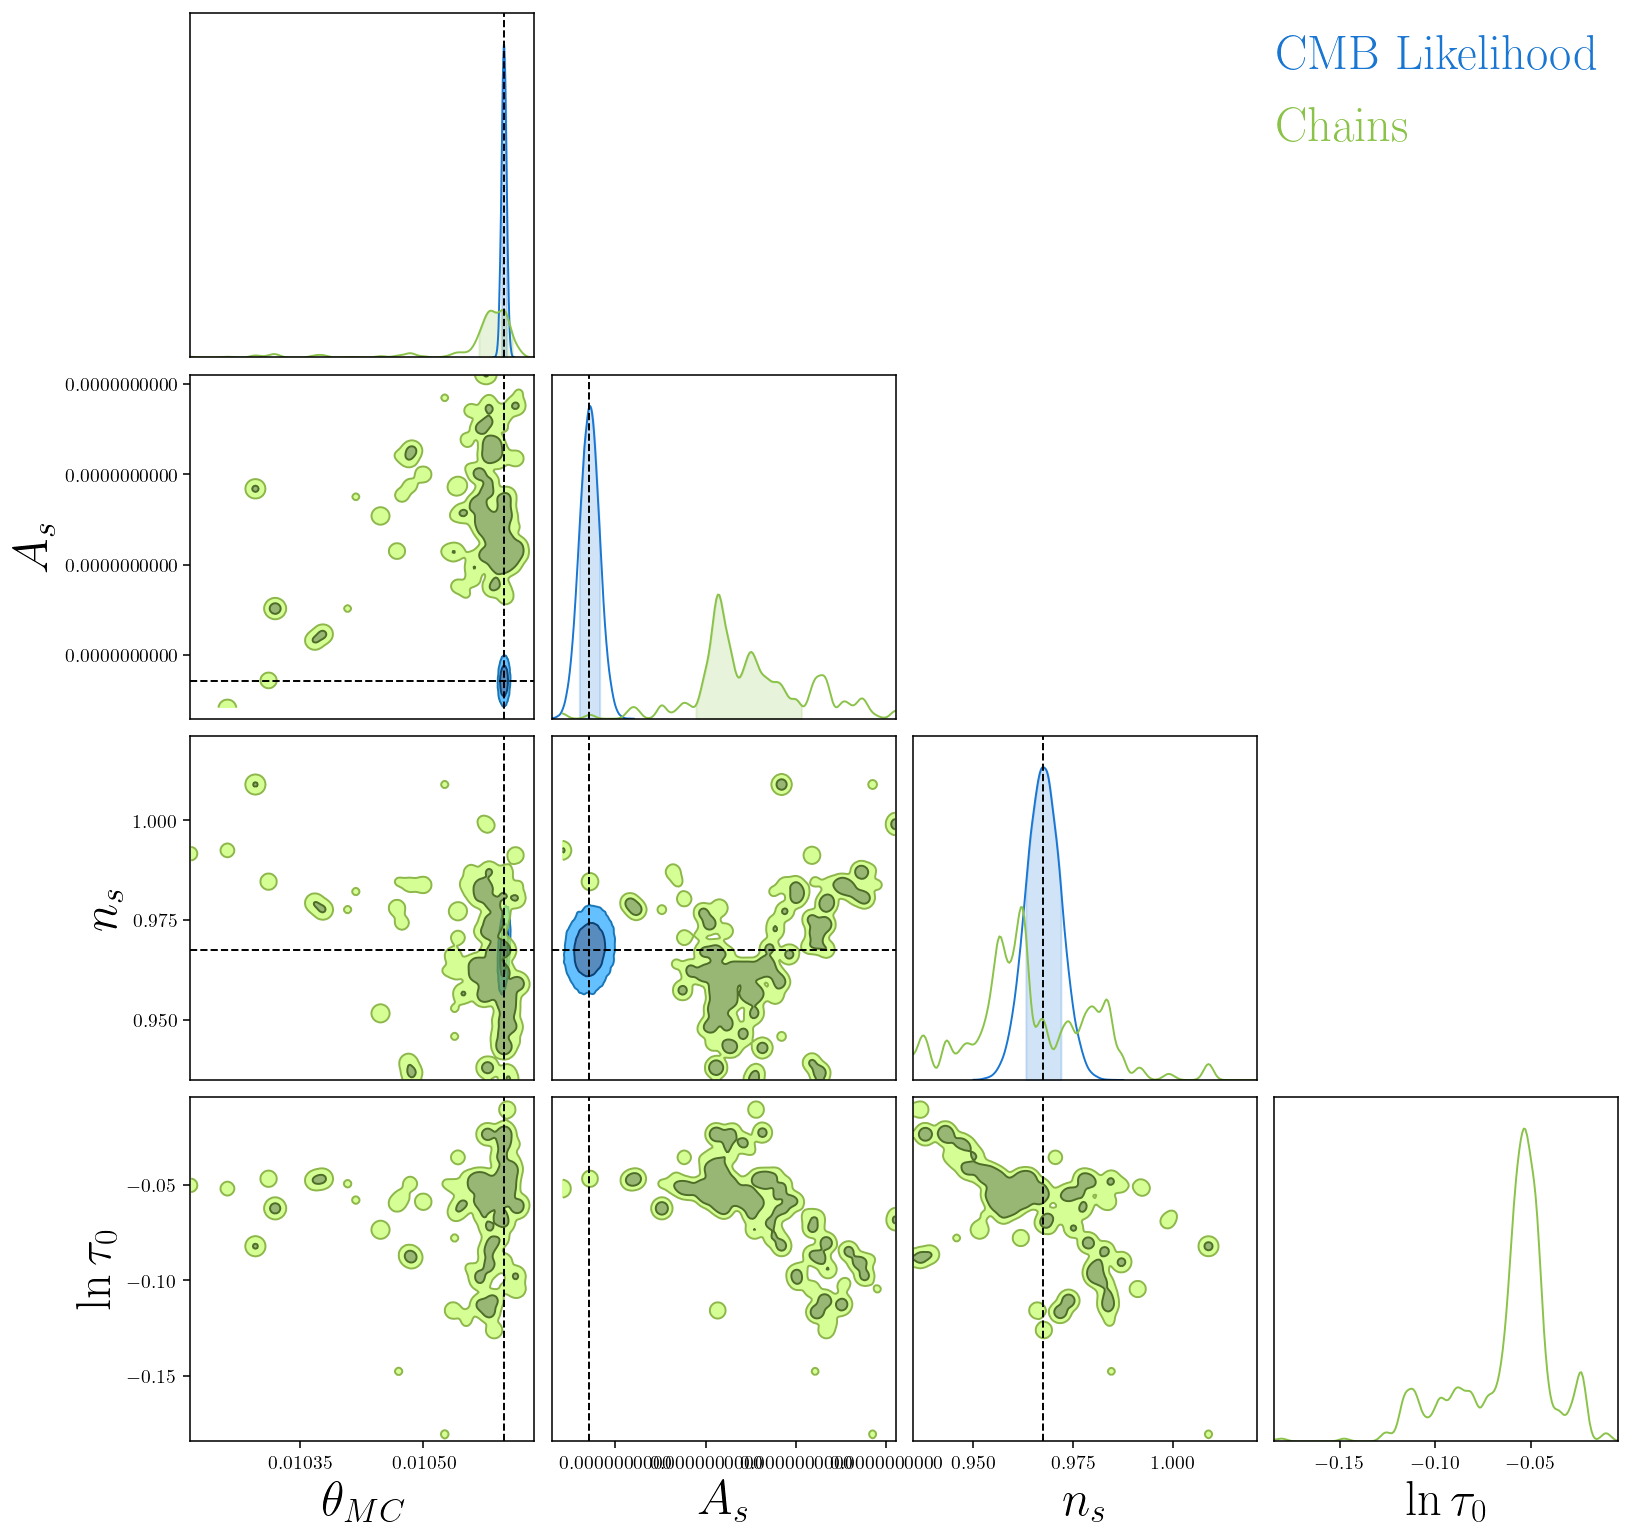

In [26]:
sampler_fc.plot_corner(cmb_prior=True)

In [27]:
blobs_fc=sampler_fc.blobs
blobs_fc['Delta2_star'][:5]

array([0.4197513 , 0.52254414, 0.52898203, 0.56961944, 0.32421163])

### Redo for lya_theory, without CMB of course

In [17]:
theory_c=lya_theory.LyaTheory(zs=data.z,emulator=emu,use_camb_fz=True)

In [28]:
# Create a likelihood object using Lya parameters
if True:
    free_param_names_c=["Delta2_star","n_star","ln_tau_0"]
    free_param_limits_c=[[0.24, 0.47], [-2.352, -2.25], [-0.2, 0.2]]
else:
    free_param_names_c=["Delta2_star","n_star","g_star","ln_tau_0"]
    free_param_limits_c=[[0.24, 0.47], [-2.352, -2.25], [0.9,1.05], [-0.2, 0.2]]
like_c=likelihood.Likelihood(data=data,theory=theory_c,
                            free_param_names=free_param_names_c,
                            free_param_limits=free_param_limits_c,
                            prior_Gauss_rms=prior,pivot_scalar=0.05,
                            include_CMB=False)

In [29]:
# Set up sampler
sampler_c=emcee_sampler.EmceeSampler(like=like_c,
                        free_param_names=free_param_names_c,verbose=False,
                        nwalkers=10,
                        save_chain=False, ## Small test run, don't create a save folder
                        progress=True)

In [31]:
n_burn_in=10
n_steps=50
start = time.time()
sampler_c.run_sampler(n_burn_in,n_steps,parallel=False)
end = time.time()
sampler_time = end - start
print("Sampling took {0:.1f} seconds".format(sampler_time))

100%|██████████| 60/60 [00:25<00:00,  2.35it/s]

Sampling took 25.8 seconds


 /Users/font/opt/anaconda3/envs/lya_cosmo/lib/python3.8/site-packages/lace-1.0.1-py3.8.egg/lace/sampler/emcee_sampler.py:724: UserWarning:Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


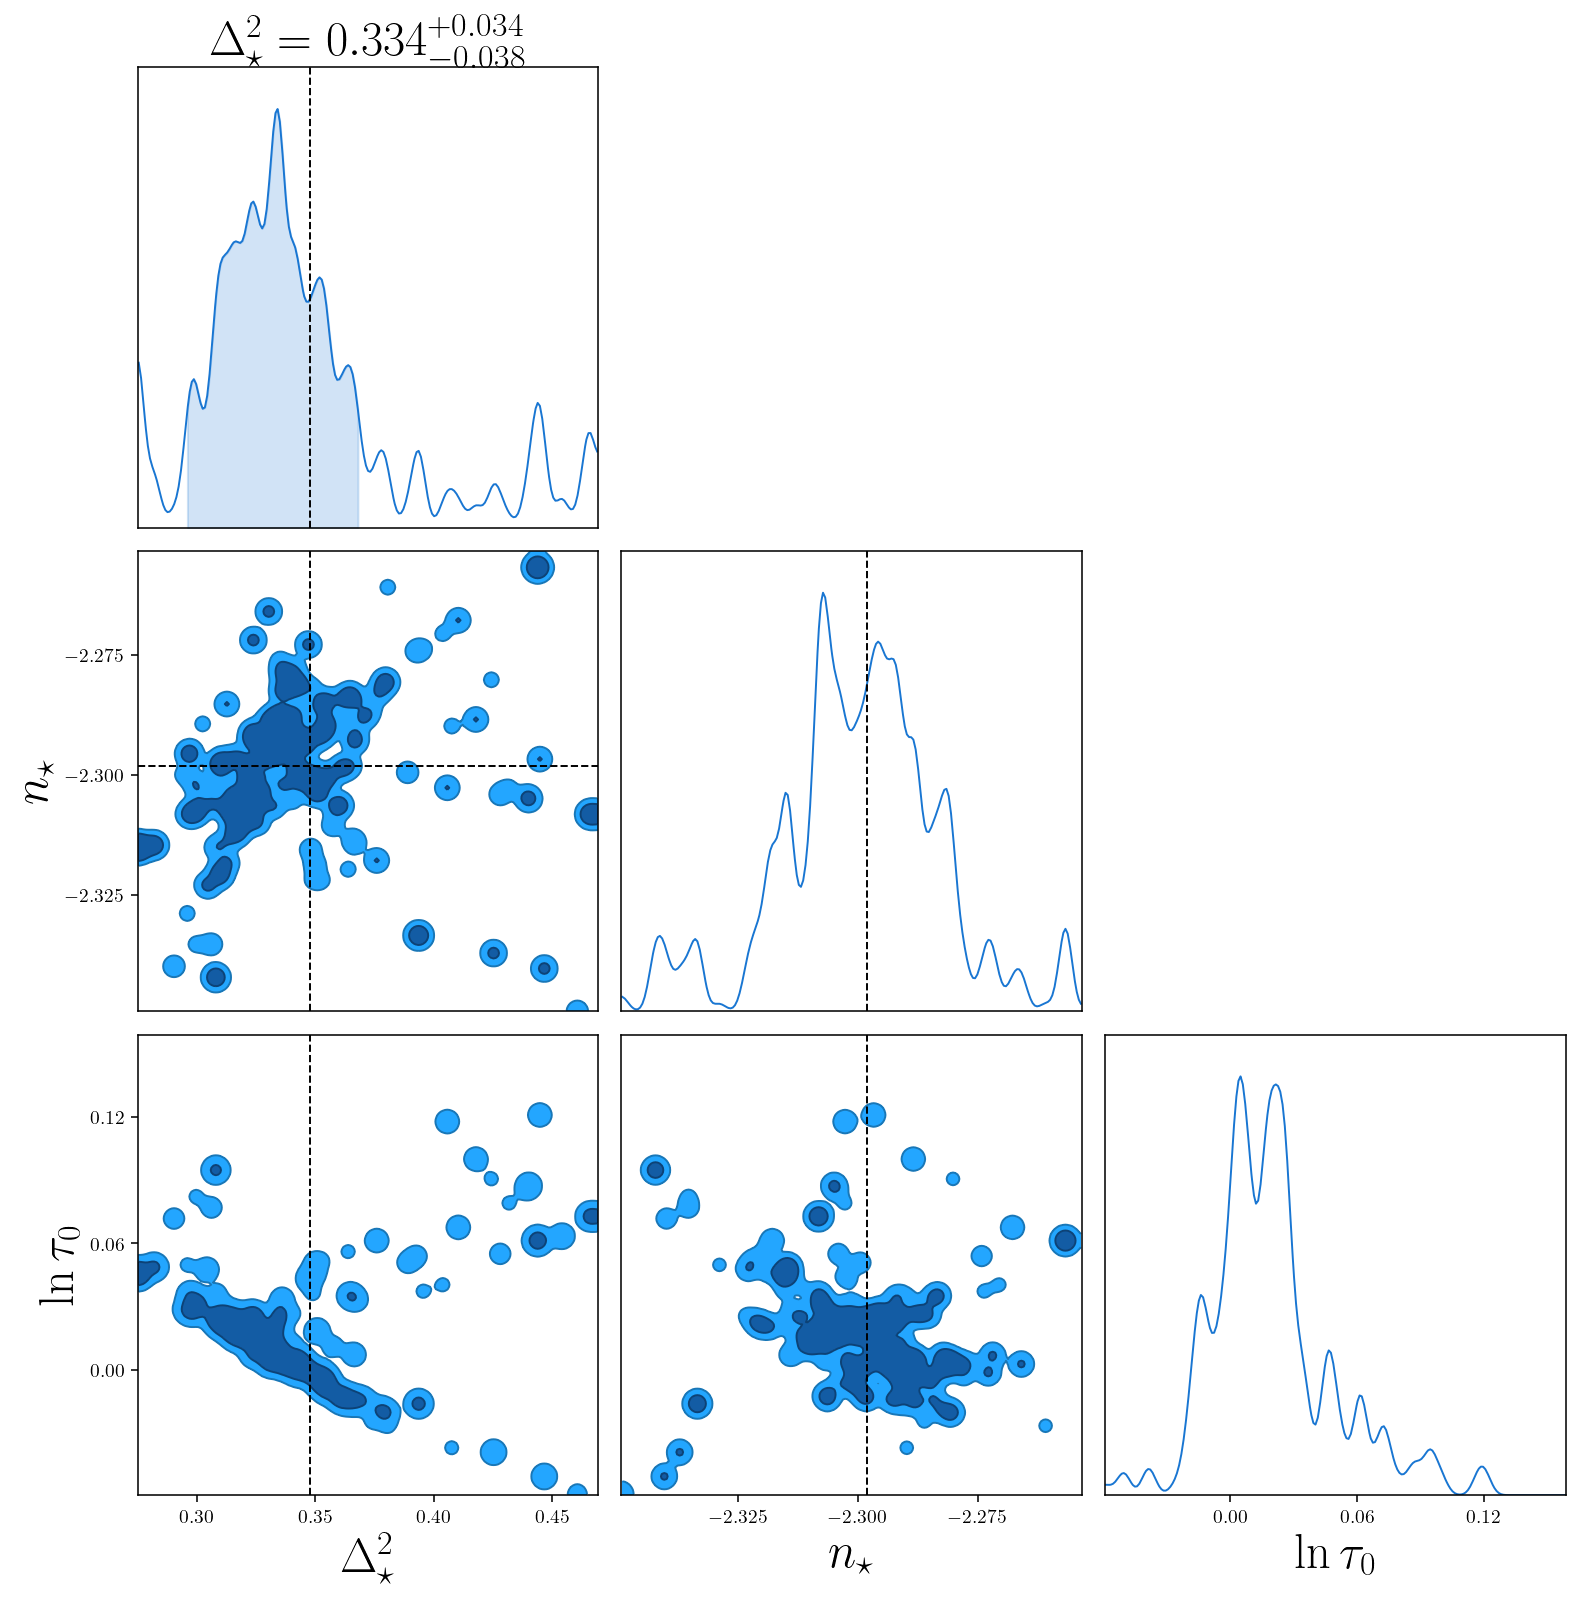

In [32]:
sampler_c.plot_corner(cmb_prior=False)

In [33]:
blobs_c=sampler_c.blobs
blobs_c['Delta2_star'][:5]

array([0.40573028, 0.31279415, 0.46955076, 0.32687264, 0.44421783])